In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u

import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics import mockstream
import gala.potential as gp
from gala.units import galactic

In [2]:
plt.style.use('notebook')

In [3]:
t = Table.read('../data/stream_track.txt', format='ascii.commented_header', delimiter=',')
tp = Table.read('../data/pvd_stream.dat', format='ascii.commented_header', delimiter=' ')

### Rotate the galaxy to lie along z=0

In [4]:
pa = 154*u.deg # https://www.flickr.com/photos/dcrowson/35166799656
theta = 64*u.deg

In [5]:
x = np.cos(theta)*t['x'] + np.sin(theta)*t['y']
z = -np.sin(theta)*t['x'] + np.cos(theta)*t['y']

xpvd = np.cos(theta)*tp['x_pvd_kpc'] + np.sin(theta)*tp['y_pvd_kpc']
zpvd = -np.sin(theta)*tp['x_pvd_kpc'] + np.cos(theta)*tp['y_pvd_kpc']

In [6]:
# progenitor as densest location on the stream
xp_rot, zp_rot = -38.7, -2.3
xp_ = np.cos(theta)*xp_rot + np.sin(theta)*zp_rot
zp_ = -np.sin(theta)*xp_rot + np.cos(theta)*zp_rot

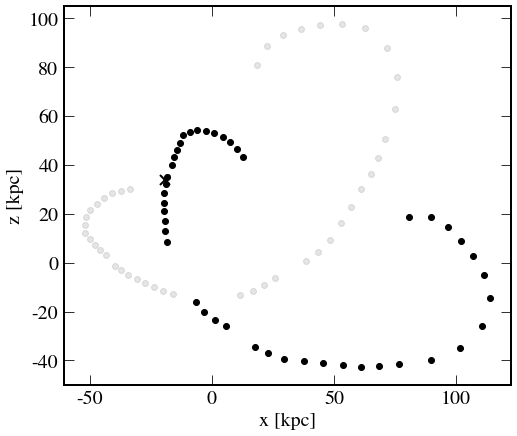

In [7]:
plt.plot(t['x'], t['y'], 'ko', alpha=0.1)
plt.plot(x, z, 'ko')
plt.plot(xp_, zp_, 'kx', ms=10, mew=2)

plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')

plt.gca().set_aspect('equal')

### Set up gravitational potential

In [8]:
# most params from Martinez-Delgado paper, + tuned halo mass to reproduce Casertano measurement of max vcirc
# https://ui.adsabs.harvard.edu/abs/2008ApJ...689..184M/abstract
# adopted halo flattening of 0.8 to match the trailing tail curvature
ham = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), 
                                          halo=dict(c=0.95, m=1.96e11*u.Msun, r_s=8.2*u.kpc),
                                          bulge=dict(m=2.3e10*u.Msun, c=0.6*u.kpc),
                                          disk=dict(m=8.4e10*u.Msun, a=6.24*u.kpc, b=0.26*u.kpc)))

maximal circular velocity 227 km / s


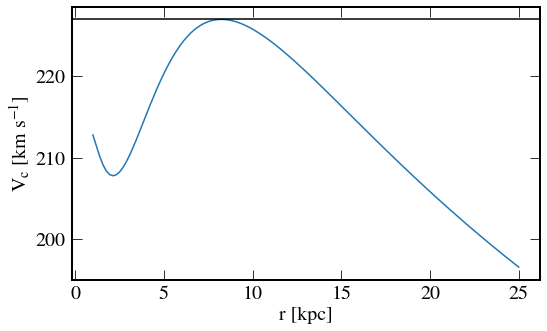

In [9]:
xyz = np.zeros((3, 128))
xyz[0] = np.linspace(1, 25, 128)
print('maximal circular velocity {:.0f}'.format(np.max(ham.potential.circular_velocity(xyz))))

plt.figure(figsize=(8,5))
plt.plot(xyz[0], ham.potential.circular_velocity(xyz))
plt.axhline(227, color='k')

plt.xlabel('r [kpc]')
plt.ylabel('$V_c$ [km s$^{-1}$]')
plt.tight_layout()

In [10]:
pot_halo = gp.NFWPotential(c=0.95, m=1.96e11*u.Msun, r_s=8.2*u.kpc)

UnitConversionError: Unit kg can not be decomposed into the requested bases

### Pick orbit for the satellite

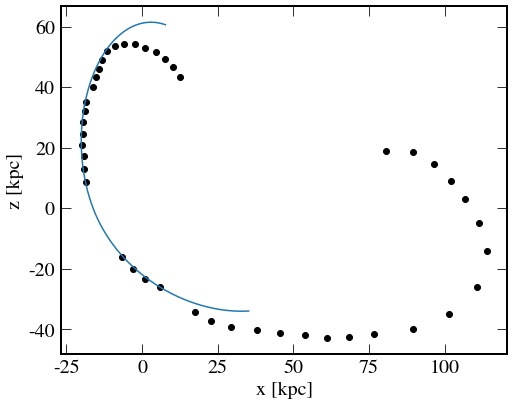

In [225]:
# trial progenitor 6D location
xp = np.array([xp_, -0, zp_]) * u.kpc
vp = np.array([45,-50,160]) * u.km/u.s

# xp = np.array([xp_, -30, zp_]) * u.kpc
# vp = np.array([40,-50,140]) * u.km/u.s
# xp = np.array([xp_, -0, zp_]) * u.kpc
# vp = np.array([35,0,175]) * u.km/u.s

xp = np.array([xp_, 0, zp_]) * u.kpc
vp = np.array([30,85,165]) * u.km/u.s


w0 = gd.PhaseSpacePosition(xp, vel=vp)

dt = 0.5*u.Myr
n_steps = 900

orbit_fwd = ham.integrate_orbit(w0, dt=dt, n_steps=n_steps)
orbit_rr = ham.integrate_orbit(w0, dt=-dt, n_steps=n_steps)

plt.plot(x, z, 'ko')
for orbit in [orbit_fwd, orbit_rr]:
    plt.plot(orbit.cartesian.x, orbit.cartesian.z, '-', color='tab:blue')

plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')

plt.gca().set_aspect('equal')

### Create a stream model

In [230]:
f = 3
prog_orbit = ham.integrate_orbit(w0, dt=-dt/f, n_steps=5200*f)
prog_orbit = prog_orbit[::-1]

n_times = np.size(prog_orbit.t)
prog_mass = np.linspace(2e8, 0, n_times)
# stream = mockstream.fardal_stream(ham, prog_orbit, prog_mass=prog_mass, release_every=1, seed=4359)

# fardal values for particle release conditions
k_mean = np.array([2., 0, 0, 0, 0.3, 0])
k_disp = np.array([0.5, 0, 0.5, 0, 0.5, 0.5])

# tweaks to reproduce smaller offset of tidal arms, trailing tail extension
k_mean = np.array([1.2, 0, 0, 0.0, 0.1, 0])
k_disp = np.array([0.5, 0, 0.5, 0.02, 0.5, 0.5])

stream = mockstream.mock_stream(ham, prog_orbit, prog_mass=prog_mass, release_every=1, seed=4359,
                               k_mean=k_mean, k_disp=k_disp)

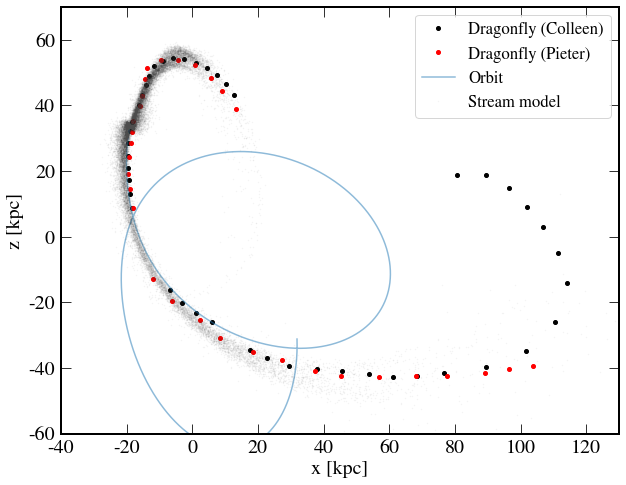

In [246]:
plt.figure(figsize=(10,10))

plt.plot(x, z, 'ko', ms=4, label='Dragonfly (Colleen)')
plt.plot(xpvd, zpvd, 'ro', ms=4, label='Dragonfly (Pieter)')
plt.plot(prog_orbit.cartesian.x, prog_orbit.cartesian.z, '-', color='tab:blue', label='Orbit', alpha=0.5)
plt.plot(stream.cartesian.x, stream.cartesian.z, '.', color='0.3', ms=1, alpha=0.05, label='Stream model')

plt.legend(fontsize='small', loc=1)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(-40,130)
plt.ylim(-60,70)

plt.gca().set_aspect('equal')
plt.savefig('../plots/trial_model_xz.png', dpi=200)

In [253]:
Ns = np.size(stream.cartesian.x)
Nsh = int(Ns/2)
Nsq = int(Ns/4)

In [237]:
xp, vp

(<Quantity [-19.03218969,   0.        ,  33.77507595] kpc>,
 <Quantity [ 30.,  85., 165.] km / s>)

In [238]:
tout_stream = Table([stream.cartesian.x, stream.cartesian.z], names=('x', 'z'))
tout_stream.write('../data/stream.fits', overwrite=True)

In [243]:
tout_orbit = Table([prog_orbit.cartesian.x, prog_orbit.cartesian.z, prog_orbit.t], names=('x', 'z', 't'))
tout_orbit.write('../data/orbit.fits', overwrite=True)